# House price analysis

## Setup

In [10]:
!pip install -Uq pandas kaggle fastai scikit-learn waterfallcharts treeinterpreter dtreeviz

In [36]:
import pandas as pd
import numpy as np
import os, zipfile
from fastai import * 
from fastai.tabular.all import *
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import *
from dtreeviz.trees import *
import graphviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Type:        module
String form: <module 'graphviz' from '/opt/conda/lib/python3.10/site-packages/graphviz/__init__.py'>
File:        /opt/conda/lib/python3.10/site-packages/graphviz/__init__.py
Source:     
# graphviz - create dot, save, render, view

"""Assemble DOT source code and render it with Graphviz.

Example:
    >>> import graphviz  # doctest: +NO_EXE
    >>> dot = graphviz.Digraph(comment='The Round Table')

    >>> dot.node('A', 'King Arthur')
    >>> dot.node('B', 'Sir Bedevere the Wise')
    >>> dot.node('L', 'Sir Lancelot the Brave')

    >>> dot.edges(['AB', 'AL'])

    >>> dot.edge('B', 'L', constraint='false')

    >>> print(dot)  #doctest: +NORMALIZE_WHITESPACE
    // The Round Table
    digraph {
        A [label="King Arthur"]
        B [label="Sir Bedevere the Wise"]
        L [label="Sir Lancelot the Brave"]
        A -> B
        A -> L
        B -> L [constraint=false]
    }
"""

from ._defaults import set_default_engine, set_default_format, set_jupyter_format


In [12]:
creds = '{"username":"divodivenson","key":"f0f9e3f8378e39e818097a5df978aa64"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [13]:
import kaggle
comp = 'house-prices-advanced-regression-techniques'
path = Path(f'../input/{comp}')
path
path.ls(file_type='text')

(#4) [Path('../input/house-prices-advanced-regression-techniques/sample_submission.csv'),Path('../input/house-prices-advanced-regression-techniques/data_description.txt'),Path('../input/house-prices-advanced-regression-techniques/train.csv'),Path('../input/house-prices-advanced-regression-techniques/test.csv')]

## First look at data


In [14]:
trn_path = path/'train.csv'
df = pd.read_csv(trn_path, low_memory=False)
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [15]:
# Lets get an idea of where the ordianls are
df.columns.map(lambda col: df[col].unique().size )

Int64Index([1460,   15,    5,  111, 1073,    2,    3,    4,    4,    2,    5,
               3,   25,    9,    8,    5,    8,   10,    9,  112,   61,    6,
               8,   15,   16,    5,  328,    4,    5,    6,    5,    5,    5,
               7,  637,    7,  144,  780,  721,    6,    5,    2,    6,  753,
             417,   24,  861,    4,    3,    4,    3,    8,    4,    4,   12,
               7,    4,    6,    7,   98,    4,    5,  441,    6,    6,    3,
             274,  202,  120,   20,   76,    8,    4,    5,    5,   21,   12,
               5,    9,    6,  663],
           dtype='int64')

In [16]:
def print_levels(level):
    if df[level].unique().size < 50:
        return f"{level} {df[level].unique()}\n"
    else:
        return f"{level} - Continuous\n"
    
df.columns.map(print_levels)

Index(['Id - Continuous\n',
       'MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]\n',
       'MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']\n',
       'LotFrontage - Continuous\n', 'LotArea - Continuous\n',
       'Street ['Pave' 'Grvl']\n', 'Alley [nan 'Grvl' 'Pave']\n',
       'LotShape ['Reg' 'IR1' 'IR2' 'IR3']\n',
       'LandContour ['Lvl' 'Bnk' 'Low' 'HLS']\n',
       'Utilities ['AllPub' 'NoSeWa']\n',
       'LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']\n',
       'LandSlope ['Gtl' 'Mod' 'Sev']\n',
       'Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'\n 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'\n 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'\n 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']\n',
       'Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']\n',
       'Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']\n',
       'Bld

In [17]:
# Make note of anything that appears to follow an order, just for reference. Not exhaustive
# Not intending to input this anywhere
# Also derived from data description https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
ordinals = ['BldgType', 'HouseStyle', 'Utilities', 'ExterCond', 'ExterQual', 'Functional', 'PavedDrive']

# There are even more, lets just go with the overall Home functionality
functional = ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
df['Functional'] = df['Functional'].astype('category')
df['Functional'].cat.set_categories(functional, ordered=True)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1455    NaN
1456    NaN
1457    NaN
1458    NaN
1459    NaN
Name: Functional, Length: 1460, dtype: category
Categories (1, object): ['TypMin1Maj1Min2ModMaj2Sev']

### Dates

In [18]:
df['saledate'] = df['MoSold'].astype(str) + '/' + df['YrSold'].astype(str)
df = add_datepart(df, 'saledate')
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [19]:
# Do the same for the test dataset
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_test['saledate'] = df_test['MoSold'].astype(str) + '/' + df_test['YrSold'].astype(str)
df_test = add_datepart(df_test, 'saledate')
df_test

,Id,MSSubClass,MSZoning,LotFrontage,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1461,20,RH,80.0,...,False,False,False,1.275350e+09
1,1462,20,RL,81.0,...,False,False,False,1.275350e+09
2,1463,60,RL,74.0,...,False,False,False,1.267402e+09
3,1464,60,RL,78.0,...,False,False,False,1.275350e+09
4,1465,120,RL,43.0,...,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,...,False,False,False,1.149120e+09
1455,2916,160,RM,21.0,...,True,False,False,1.143850e+09
1456,2917,20,RL,160.0,...,False,False,False,1.157069e+09
1457,2918,85,RL,62.0,...,True,False,False,1.151712e+09


### Depedent variable

`SalePrice` is the dependent variable. We are told the evaluation is on the RMSE between the log of the predicted and actual sale price (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [20]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

## Decision Tree
First lets have a go at building a plain old decision tree and submit that to Kaggle

### Test and validation set
In this case I don't see the test set contain future dates compared to the training set, so my first attempt at a validation set will just take a random sample of the training set.

In [21]:
df['YrSold'].unique(), df_test['YrSold'].unique()

(array([2008, 2007, 2006, 2009, 2010]), array([2010, 2009, 2008, 2007, 2006]))

In [22]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2)
df_train.size, df_valid.size
# Need to get the index from the row in df of all the fields in df_valid
train_idx = df_train.Id.map(lambda id: df.index[df.Id == id][0])
valid_idx = df_valid.Id.map(lambda id: df.index[df.Id == id][0])
splits = (list(train_idx), list(valid_idx))

### Handle missing data and strings
Sklearn cannot handle missing data or strings.

`Categorify` is a TabularProc that replaces a column with a numeric categorical column. 

`FillMissing` is a TabularProc that replaces missing values with the median of the column

In [23]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing]
tabular_data = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
tabular_data.show(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,saleDay,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,saleYear,saleMonth,saleWeek,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
331,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Fa,Y,SBrkr,TA,Typ,#na#,Attchd,RFn,TA,TA,Y,#na#,#na#,#na#,WD,Normal,1,False,True,False,False,False,False,False,False,False,332,20,70.0,8176,5,6,1958,1992,0.0,846,0,210,1056,1056,0,0,1056,1,0,1,0,3,1,6,0,1958.0,1,308,0,0,0,0,0,0,0,8,2007,2007,8,31,2,213,1.185926e+09,11.842229
1443,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,Grav,Fa,N,FuseF,Fa,Typ,Gd,Detchd,Unf,Fa,Po,P,#na#,#na#,#na#,WD,Normal,1,False,True,False,False,False,False,True,False,False,1444,30,69.0,8854,6,6,1916,1950,0.0,0,0,952,952,952,0,0,952,0,0,1,0,2,1,4,1,1916.0,1,192,0,98,0,0,40,0,0,5,2009,2009,5,18,4,121,1.241136e+09,11.703546
1167,RL,Pave,#na#,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,1,False,True,False,False,False,False,False,False,False,1168,60,58.0,10852,6,5,2000,2000,0.0,786,0,173,959,959,712,0,1671,1,0,2,1,3,1,7,1,2000.0,2,472,0,38,0,0,0,0,0,2,2006,2006,2,5,2,32,1.138752e+09,12.061047


The underlying data is now all numeric

In [24]:
tabular_data.items.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,...,saleElapsed,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
331,332,20,4,70.0,...,1.185926e+09,1,1,1


## Creating the decision tree

In [38]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

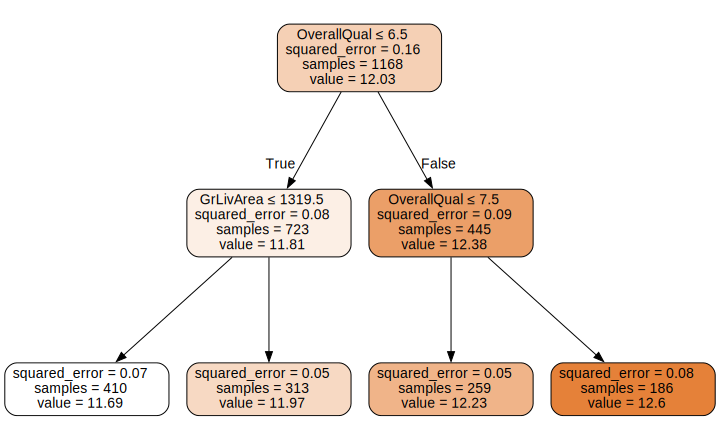

In [39]:
xs, y = tabular_data.train.xs, tabular_data.train.y # The independent and dependent params
valid_xs, valid_y = tabular_data.valid.xs, tabular_data.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)